# Terminal Link Optimization

This is the main jupyter notebook script for optimizing the dilvery of keys from the CubeSat to upcoming ground terminals in network. Four independent approaches are used: grid search, random search, function minimization and Markov Chain Monte Carlo. We find that although grid search is typically 3X slower than other techniques, it is the optimal approach.

## Import packages

The two simplest approaches (grid search and random search) use simple numpy functions. The function minimization approach uses scipy. The MCMC approach uses both the emcee and pymc3 packages.

In [12]:
pip install emcee

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import time

# import pymc3 module
import pymc3 as pm
import emcee
print('emcee version: {}'.format(emcee.__version__))


#from tensorflow.keras import datasets, layers, models

emcee version: 3.0.2


## Make simulation of satellite and customers

Each customer is given 4 attributes in the following order: Index within the set, physical distance location, importantness factor (predetermined by Craft Prospect) and a weather indicator. Distance is defined to be between 0 and `max_dist`. Both weather and importantness are defined randomly along a uniform distribution between 0 and 1.

In [0]:
"""
Lets make an array containing the physical location of some simulated customers.
The array will have the shape (N_time_segments,length_of_time_segment)

customer data array `customer_arr` will be of shape (number of training orbits, number of customers 
in orbit, number of features describing priority of customers)
"""

# training set hyperparameters
num_customers = 100                                   # total number of customers on planet for each training sample
num_orbits = 10000                                    # total number of training samples
max_dist = 1000                                       # maximum distance allowed for customers
dist_step = 50                                        # distance traveled per step by satellite
obs_window = 200                                      # total size of observation window of satellite in units of distance
customer_arr = np.zeros((num_orbits,num_customers,5)) # Define emtpy array to contain customer data

# neural network hyperparameters
batch_size = 64                                       # batch size (number of samples given to NN for each training epoch)

####################
# Make training set#
####################

# iterate over number of training samples (where one sample is defined as a single orbit around the Earth)
for i in range(num_orbits):

    # Make customer index labels
    customer_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer importantness factor. 0 == low importance, 1 == high importance
    customer_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

# Testing set hyperparameters
num_test_orbits = 100 # number of test samples to use
customer_test_arr = np.zeros((num_test_orbits,num_customers,5))

################
# Make test set#
################

for i in range(num_test_orbits):
  
    # Make customer index labels
    customer_test_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_test_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer importantness factor. 0 == low importance, 1 == high importance
    customer_test_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_test_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

# reshape training and testing arrays
X_train = customer_arr[:,:,1:4]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = customer_test_arr[:,:,1:4].reshape(num_test_orbits,num_customers,3,1)
Y_train = np.ones((num_orbits,num_customers))
Y_test = np.ones((num_test_orbits,num_customers))

## Key delivery without any optimization

This is an incredibly simple algorithm which only takes into account 
the importantness and weather factors for each customer. It does not 
take into account the total time customers have been waiting for 
a key to be distributed to them.

In [0]:
# Loop over all available customers within line-of-sight (this is by default set to num_customers)

# This is an example using only one training orbit.
for i in range(num_customers):
    customer_arr[0,i,4] = customer_arr[0,i,2] * customer_arr[0,i,3]

customer_prob_list_idx = np.argsort(customer_arr[0,:,4])
customer_prob_list = customer_arr[0,customer_prob_list_idx,0]

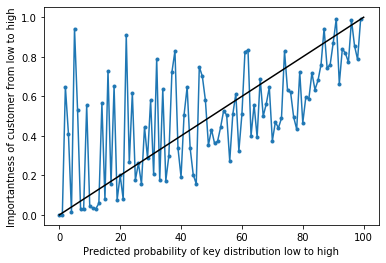

In [0]:
# Plot importantness as a function of predicted key probability
plt.plot(customer_arr[0,customer_prob_list_idx,2], marker='.')
plt.plot(np.linspace(0, num_customers, num_customers), np.linspace(0, 1, num_customers), color='k')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('Importantness of customer from low to high')
plt.show()

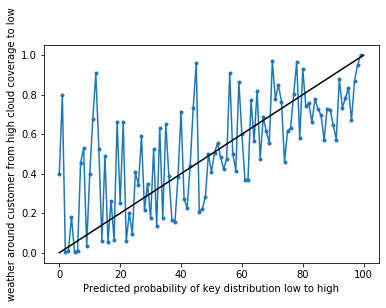

In [0]:
# Plot weather as a function of predicted key probability
plt.close()
plt.plot(customer_arr[0,customer_prob_list_idx,3], marker='.')
plt.plot(np.linspace(0, num_customers, num_customers), np.linspace(0, 1, num_customers), color='k')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('weather around customer from high cloud coverage to low')
plt.show()

In [0]:
def window(d,dist_cnt):
  """" window length function. one-sidded gaussian."""
  sigma = obs_window
  a = np.sqrt(2) / (sigma * np.sqrt(np.pi))
  x = d
  return a*np.exp(-(x)**2/(2*sigma**2)) + dist_cnt

def simulate_satellite_orbit(alpha_values, orb_idx, total_delivered, cust_prob,
                             customers_accessed, 
                             scipy_optim_flag=False):
  """simulate one orbit of satellite given orbital training set"""
  alpha_I = alpha_values[0]
  alpha_w = alpha_values[1]
  alpha_d = alpha_values[2]

  # if doing function optimization approach, reset every iteration
  if scipy_optim_flag == True:
    total_delivered = 0

  # declare temparary variables which will be changed if better alpha values found
  tmp_cust_prob = np.zeros((num_customers))
  tmp_total_delivered = 0
   
  # define updatable variables to be used while iterating through customers in current sample
  dist_cnt = 0                # record of distance traveled

  # Simulate satellite traveling until maximum distance reached (defined as 1 orbit around Earth)
  while dist_cnt <= max_dist:       

    # make empty lists to store customers in current operating window
    customers_in_cur_wind_prob = []
    customers_in_cur_wind_idx = []
    customers_in_cur_wind_feat = []

    # Iterate over all customers around the globe
    for customer_idx,customer in enumerate(customer_arr[orb_idx,:,:]):

      # Check if customer has already had a key distributed to them
      try:
          customers_accessed.index(customer_idx)

      # if customer hasn't had a key delivered, continue on and append to window
      except ValueError:
          pass

      # if customer has already had their key delivered, move on to next customer without appending to window
      else:
          continue

      # Append the index of the customer
      customers_in_cur_wind_idx.append(customer_idx)

      # Append loss value of customer
      customers_in_cur_wind_feat.append(alpha_I * customer[2] +  
                      alpha_w * customer[3]) #+ 
                      #alpha_d * window(customer[1], dist_cnt)) 

    # If there are no customers within the current line-of-sight or I've chosen to wait for the next one, add some small distance traveled by satellite
    if not customers_in_cur_wind_idx:
      dist_cnt+=dist_step
      continue
    elif customer_arr[orb_idx,customers_in_cur_wind_idx[np.argmax(customers_in_cur_wind_feat)],1] > (dist_cnt + obs_window):
      dist_cnt+=dist_step
      continue

    # take maximal likely customer in current window and record their liklihood
    tmp_cust_prob[customer_idx] = np.max(customers_in_cur_wind_feat)

    # add customer to list of keys already delivered
    customers_accessed.append(customers_in_cur_wind_idx[np.argmax(customers_in_cur_wind_feat)])
    tmp_total_delivered += 1
      
    # add a distance traveled by satellite equivalent to time to deliver key
    dist_cnt += dist_step

  # check if the total number of keys delivered is more than the best so far
  if abs(tmp_total_delivered) > abs(total_delivered):
      total_delivered = tmp_total_delivered
      cust_prob = tmp_cust_prob 
#      print('Total delivered has increased to: %d' % total_delivered)

  if scipy_optim_flag == True:
    return -tmp_total_delivered
  else:
    return total_delivered, cust_prob

## Grid search approach

Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid (alpha_I, alpha_w, alpha_d).

We first define the range over which these tunable hyperparameters can be (i.e. 0 - 1). The grid, in this case, has values ranging from 0 to 1 in steps defined by the variable `grid_size`. We then construct many versions of the model using every combination of values in the grid. The optimal result is achieved according which corresponding grid points return the maximum number of keys delivered. 

In [0]:
# tunable weights
alpha_I = 1.0
alpha_w = 1.0
alpha_d = 1.0

# sparcity of grid space
grid_size = 10

# array to be filled with liklihood of key delivered to customer
cust_prob = np.zeros((num_orbits,num_customers,1))

dist_idx = 0
orb_idx = 0 # currently set to first training set sample. will add another for loop later
keys_delivered = 0 # set the number of keys delivered initially to zero

# iterate through one orbit using the first training sample 
while dist_idx < max_dist:

  # declare total keys delivered over current training sample to be zero initially
  total_delivered = 0

  # set there to be no keys initially delivered
  if dist_idx == 0:
    customers_accessed_outside = []

  t0 = time.time()
  # run a grid search over all 3 tunable parameters
  for alpha_I in np.linspace(1,100,grid_size):
    for alpha_w in np.linspace(1,100,grid_size):
      for alpha_d in np.linspace(1,100,grid_size):

        # simulate one orbit of satellite
        alpha_values = np.array([alpha_I,alpha_w,alpha_d])
        total_delivered, cust_prob = simulate_satellite_orbit(alpha_values,orb_idx,total_delivered,
                                                              cust_prob,customers_accessed_outside)
        
  # record time to compute
  t1 = time.time()
  total_time = t1-t0

  # deliver key
  customers_accessed_outside.append(np.argmax(cust_prob))
  keys_delivered += 1
  print('Distance (m): %d/%d, time_to_execute: %.6f' % (dist_idx,max_dist,total_time))
  print('Number of keys delivered: %d/%d' % (keys_delivered,num_customers))

  # add some distance traveled by satellite
  dist_idx += dist_step

Distance (m): 0/1000, time_to_execute: 2.225444
Number of keys delivered: 1/100
Distance (m): 50/1000, time_to_execute: 2.229401
Number of keys delivered: 2/100
Distance (m): 100/1000, time_to_execute: 2.238214
Number of keys delivered: 3/100
Distance (m): 150/1000, time_to_execute: 2.211757
Number of keys delivered: 4/100
Distance (m): 200/1000, time_to_execute: 2.211896
Number of keys delivered: 5/100
Distance (m): 250/1000, time_to_execute: 2.191294
Number of keys delivered: 6/100
Distance (m): 300/1000, time_to_execute: 2.208836
Number of keys delivered: 7/100
Distance (m): 350/1000, time_to_execute: 2.189931
Number of keys delivered: 8/100
Distance (m): 400/1000, time_to_execute: 2.174918
Number of keys delivered: 9/100
Distance (m): 450/1000, time_to_execute: 2.165758
Number of keys delivered: 10/100
Distance (m): 500/1000, time_to_execute: 2.179673
Number of keys delivered: 11/100
Distance (m): 550/1000, time_to_execute: 2.211885
Number of keys delivered: 12/100
Distance (m): 60

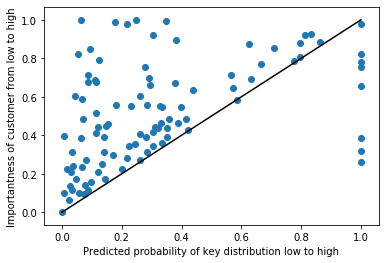

In [0]:
# Plot importantness as a function of predicted key probability
plt.scatter(batch_feature_data[0,:,4],customer_arr[0,:,2])
plt.plot(np.linspace(0, 1.0, num_customers), np.linspace(0, 1, num_customers), color='k')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('Importantness of customer from low to high')
plt.show()

## Random grid search approach

The idea of random searching of hyperparameters was proposed by James Bergstra & Yoshua Bengio.

Random search differs from a grid search in that you no longer provide a discrete set of values to explore for each hyperparameter; rather, you provide a statistical distribution for each hyperparameter from which values may be randomly sampled. In this case, we draw our tunable hyperparameters from a uniform distribution.

In [0]:
# tunable weights
alpha_I = 1.0
alpha_w = 1.0
alpha_d = 1.0

# sparcity of grid space
grid_size = 10

# array to be filled with liklihood of key delivered to customer
cust_prob = np.zeros((num_orbits,num_customers,1))

dist_idx = 0
orb_idx = 0 # currently set to first training set sample. will add another for loop later
keys_delivered = 0 # set the number of keys delivered initially to zero

# iterate through one orbit using the first training sample 
while dist_idx < max_dist:

  # declare total keys delivered over current training sample to be zero initially
  total_delivered = 0

  # set there to be no keys initially delivered
  if dist_idx == 0:
    customers_accessed_outside = []

  t0 = time.time()
  # run a grid search over all 3 tunable parameters
  for alpha_I in np.random.uniform(0,1,size=(grid_size)):
    for alpha_w in np.random.uniform(0,1,size=(grid_size)):
      for alpha_d in np.random.uniform(0,1,size=(grid_size)):

        # simulate one orbit of satellite
        alpha_values = np.array([alpha_I,alpha_w,alpha_d])
        total_delivered, cust_prob = simulate_satellite_orbit(alpha_values,orb_idx,total_delivered,
                                                              cust_prob,customers_accessed_outside)
        
  # record time to compute
  t1 = time.time()
  total_time = t1-t0

  # deliver key
  customers_accessed_outside.append(np.argmax(cust_prob))
  keys_delivered += 1
  print('Distance (m): %d/%d, time_to_execute: %.6f' % (dist_idx,max_dist,total_time))
  print('Number of keys delivered: %d/%d' % (keys_delivered,num_customers))

  # add some distance traveled by satellite
  dist_idx += dist_step

Distance (m): 0/1000, time_to_execute: 2.209883
Number of keys delivered: 1/100
Distance (m): 50/1000, time_to_execute: 2.168596
Number of keys delivered: 2/100
Distance (m): 100/1000, time_to_execute: 2.158899
Number of keys delivered: 3/100
Distance (m): 150/1000, time_to_execute: 2.172915
Number of keys delivered: 4/100
Distance (m): 200/1000, time_to_execute: 2.187762
Number of keys delivered: 5/100
Distance (m): 250/1000, time_to_execute: 2.158664
Number of keys delivered: 6/100
Distance (m): 300/1000, time_to_execute: 2.166448
Number of keys delivered: 7/100
Distance (m): 350/1000, time_to_execute: 2.177465
Number of keys delivered: 8/100
Distance (m): 400/1000, time_to_execute: 2.174939
Number of keys delivered: 9/100
Distance (m): 450/1000, time_to_execute: 2.182907
Number of keys delivered: 10/100
Distance (m): 500/1000, time_to_execute: 2.175503
Number of keys delivered: 11/100
Distance (m): 550/1000, time_to_execute: 2.149220
Number of keys delivered: 12/100
Distance (m): 60

"\n# iterate over all samples in training set \nfor orb_idx in range(num_orbits):\n\n  # declare total keys delivered over current training sample to be zero initially\n  total_delivered = 0\n\n  t0 = time.time()\n\n  # run a random grid search between 0 and 1 over all 3 tunable parameters\n  for alpha_I in np.random.uniform(low=0.0,high=1.0,size=(grid_size)):\n    for alpha_w in np.random.uniform(low=0.0,high=1.0,size=(grid_size)):\n      for alpha_d in np.random.uniform(low=0.0,high=1.0,size=(grid_size)):\n\n        # simulate one orbit of satellite\n        alpha_values = np.array([alpha_I,alpha_w,alpha_d])\n        total_delivered, cust_prob = simulate_satellite_orbit(alpha_values,orb_idx,total_delivered,cust_prob)\n\n  # record time to compute\n  t1 = time.time()\n  total_time = t1-t0\n  print('Orbit: %d/%d, total time to execute: %.6f' % (orb_idx,num_orbits,total_time))\n  done\n"

# Genetic Algorithm approach

An approach using a genetic algorithm. This closely follows the following towradsdatascience article (https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6)

In [0]:
class ga:
    """ Class which contains genetic algorithm routines """

    def cal_pop_fitness(equation_inputs, pop):
        # Calculating the fitness value of each solution in the current population.
        # The fitness function caulcuates the sum of products between each input and its corresponding weight.
        fitness = np.sum(pop*equation_inputs, axis=1)
        return fitness

    def select_mating_pool(pop, fitness, num_parents):
        # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        parents = np.empty((num_parents, pop.shape[1]))
        for parent_num in range(num_parents):
            max_fitness_idx = np.where(fitness == np.max(fitness))
            max_fitness_idx = max_fitness_idx[0][0]
            parents[parent_num, :] = pop[max_fitness_idx, :]
            fitness[max_fitness_idx] = -99999999999
        return parents

    def crossover(parents, offspring_size):
        offspring = np.empty(offspring_size)
        # The point at which crossover takes place between two parents. Usually it is at the center.
        crossover_point = np.uint8(offspring_size[1]/2)

        for k in range(offspring_size[0]):
            # Index of the first parent to mate.
            parent1_idx = k%parents.shape[0]
            # Index of the second parent to mate.
            parent2_idx = (k+1)%parents.shape[0]
            # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
            # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

    def mutation(offspring_crossover):
        # Mutation changes a single gene in each offspring randomly.
        for idx in range(offspring_crossover.shape[0]):
            # The random value to be added to the gene.
            random_value = np.random.uniform(-1.0, 1.0, 1)
            offspring_crossover[idx, 4] = offspring_crossover[idx, 4] + random_value
        return offspring_crossover

In [19]:
"""
The y=target is to maximize this equation ASAP:
    y = w1x1+w2x2+w3x3+w4x4+w5x5+6wx6
    where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7)
    What are the best values for the 6 weights w1 to w6?
    We are going to use the genetic algorithm for the best possible values after a number of generations.
"""

# Inputs of the equation.
equation_inputs = [4,-2,3.5,5,-11,-4.7]

# Number of the weights we are looking to optimize.
num_weights = 6

"""
Genetic algorithm parameters:
    Mating pool size
    Population size
"""
sol_per_pop = 8
num_parents_mating = 4

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
# Creating the initial population.
new_population = np.random.uniform(low=-4.0, high=4.0, size=pop_size)
print(new_population)

num_generations = 5
for generation in range(num_generations):
    print("Generation : ", generation)
    # Measing the fitness of each chromosome in the population.
    fitness = ga.cal_pop_fitness(equation_inputs, new_population)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents,
                                       offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = ga.mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The best result in the current iteration.
    print("Best result : ", np.max(np.sum(new_population*equation_inputs, axis=1)))

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness = ga.cal_pop_fitness(equation_inputs, new_population)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])

[[ 3.41058202  1.87705406 -2.72554747 -0.20425706  2.25672034 -0.06847779]
 [ 3.77927105  3.31377217 -0.33139204  2.98938895 -3.02886416  2.7817044 ]
 [-0.6089331   2.26650562 -0.12722209 -3.21907605  1.0115203   2.40115522]
 [ 2.88169422 -3.06835627 -1.18418419  3.76580247 -3.90323853 -0.06228135]
 [ 3.93745267 -2.50201382  1.0926137   2.2658849   1.5363268   3.73584984]
 [ 2.12088219  1.2910508   0.52193321  1.17628408 -2.02367356 -1.55459427]
 [-0.58884551  0.34239715  2.22303273 -0.30796046  0.91455601 -0.32048269]
 [-2.6159705   1.63568354  0.178851   -0.87183929 -0.80706269  2.02144107]]
Generation :  0
Best result :  92.89682594576817
Generation :  1
Best result :  92.94926956156449
Generation :  2
Best result :  113.076252627512
Generation :  3
Best result :  113.076252627512
Generation :  4
Best result :  122.43946795893574
Best solution :  [[[ 3.93745267 -2.50201382  1.0926137   3.76580247 -7.15815882
   -0.06228135]]]
Best solution fitness :  [122.43946796]


## Emcee approach
This will maximize a log probability. So I think I need to make the function positive rather than negative.

In [0]:
# define some hyperparameters
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

In [0]:
# define log posterior, prior and liklihood
def logposterior(theta, data, total_delivered, cust_prob):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual tunable parameter values.
        data (list): the set of data/observations. In other
        words, the properties which describe each customer on the ground.
        x (list): the abscissa values at which the data/model is defined. In other
        words, the properties which describe each customer on the ground.
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likelihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, total_delivered, cust_prob)

def loglikelihood(theta, data, total_delivered, cust_prob):
    """
    The natural logarithm of the joint likelihood.

    Args:
        theta (tuple): a sample containing individual tunable parameter values
        data (list): the set of data/observations. In other
        words, the properties which describe each customer on the ground.
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined. In other
        words, the properties which describe each customer on the ground.

    Note:
        We do not include the normalisation constants (as discussed above).
    """

    # evaluate the model/simulation
    md, cust_prob = simulate_satellite_orbit(theta,orb_idx,total_delivered,cust_prob)

    # return the log likelihood. (Hunter) Should be a positive number?
    return np.log(md)

def logprior(theta):
    """
    The natural logarithm of the prior probability.

    Args:
        theta (tuple): a sample containing individual tunable parameter values

    Note:
        We can ignore the normalisations of the prior here.
    """

    lp = 0.

    # unpack the model parameters from the tuple
    alpha_I = theta[0]
    alpha_w = theta[1]
    alpha_d = theta[2]

    # uniform prior on alpha_I
    alpha_I_min = 0.0 # lower range of prior
    alpha_I_max = 1.0  # upper range of prior

    # uniform prior on alpha_w
    alpha_w_min = 0.0 # lower range of prior
    alpha_w_max = 1.0  # upper range of prior

    # uniform prior on alpha_d
    alpha_d_min = 0.0 # lower range of prior
    alpha_d_max = 1.0  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if alpha_I_min < alpha_I < alpha_I_max else -np.inf

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if alpha_w_min < alpha_w < alpha_w_max else -np.inf

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if alpha_d_min < alpha_d < alpha_d_max else -np.inf    

    # Gaussian prior on m
    #mmu = 0.     # mean of the Gaussian prior
    #msigma = 10. # standard deviation of the Gaussian prior
    #lp -= 0.5*((m - mmu)/msigma)**2

    return lp

In [0]:
data = []
sigma = []
x = []

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

In [0]:
""" Now we can run the sampler! """

# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

## Function optimization approach

Doesn't work signficantly better than the random search approach, but I could be doing something wrong with the arguments of the function.

In [0]:
import numpy as np
from scipy.optimize import minimize

In [0]:
# set total delivered keys initially to zero
total_delivered = None
orb_idx = 0

# array to be filled with liklihood of key delivered to customer
cust_prob = np.zeros((num_orbits,num_customers,1))

# sparcity of grid space
grid_size = 10

# define initial guesses for the tunable hyperparameters
alpha_values_0 = np.random.uniform(low=0.0, high=1.0, size=3)

# tell function to only return the number of keys delivered (this is specifically for the scipy minimization procedure)
scipy_optim_flag = True

t0 = time.time()
# minimize the function
res = minimize(simulate_satellite_orbit, alpha_values_0, args=(orb_idx,total_delivered,cust_prob,scipy_optim_flag), method='Nelder-Mead', tol=1e-12,
               options={'disp': True})
t1 = time.time()
total_time = t1-t0
print('Total time to optimize: %.6f' % total_time)

Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
Total delivered has increased to: 13
T

In [0]:
res.x

array([0.0652295 , 0.49421507, 0.33673122])

In [0]:
 alpha_values = res.x
 total_delivered, cust_prob = simulate_satellite_orbit(alpha_values,orb_idx,total_delivered,
                                                              cust_prob)
 print(total_delivered)

17


## Pymc3 approach

In [0]:
import pymc3 as pm
from pymc3 import *
!pip install corner

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11643 sha256=222c5ce76a8767866b3ddb6da38098afa6f366576acb957a1051de152f157877
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import corner

In [0]:
N_SAMPLES = 1
y = np.linspace(0, 1, num_customers)
x = batch_feature_data[0,:,2] * batch_feature_data[0,:,3]

with pm.Model() as model:

    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sigma=20)
    x_coeff = Normal('x', 0, sigma=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * (batch_feature_data[0,:,2] * 
                                               batch_feature_data[0,:,3]),
                        sigma=sigma, observed=y)

    # Inference!
    trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling
    
    """
    # Create the alpha and beta parameters
    # Assume a uniform distribution for customer factors
    alpha_i = pm.Uniform('alpha', lower=0.0, upper=1.0)
    alpha_w = pm.Uniform('beta', lower=0.0, upper=1.0)
    
    # The sleep probability is modeled as a logistic function
    p = pm.Deterministic('p', alpha_i * alpha_w)
    
    # Create the bernoulli parameter which uses observed data to inform the algorithm
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Draw the specified number of samples
    sleep_trace = pm.sample(N_SAMPLES, step=step);
    """

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:10<00:00, 662.46draws/s]
The acceptance probability does not match the target. It is 0.8788238061031783, but should be close to 0.8. Try to increase the number of tuning steps.


In [0]:
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.479099,0.048414,0.000685,0.385118,0.571726,3397.024420,1.000096
x,0.085556,0.158708,0.002573,-0.239731,0.380710,3136.921913,1.000491
sigma,0.298162,0.021774,0.000364,0.257168,0.340624,3839.650004,0.999853


In [0]:
cust_idx = 2
print(batch_feature_data[0,cust_idx,2], batch_feature_data[0,cust_idx,3])
print(0.085556 * (batch_feature_data[0,cust_idx,2] * batch_feature_data[0,cust_idx,3]) + 0.479099)

0.33764414905686424 0.3925981599911167
0.49044017260061495


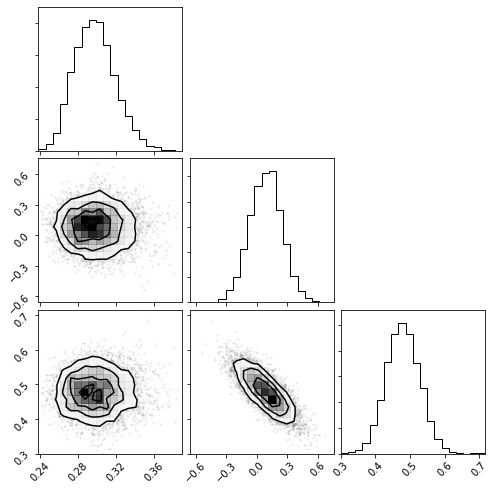

In [0]:

fig = corner.corner(np.array([trace['sigma'],trace['x'], trace['Intercept']]).T)

# Pymc3 approach


In [0]:
# define model
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    model.basic_RVs
    model.free_RVs
    model.observed_RVs
    model.logp({'mu': 0})

    
